In [33]:
import sys
sys.path.append("..")
import pandas as pd
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
from utils import *
from scipy.fft import fft
import os
from jax import random
from jax.experimental.optimizers import adam, sgd
from jax import numpy as jnp
%load_ext autoreload
%autoreload 2
from tqdm import tqdm
from functools import partial

from utils import Shuffler


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [238]:
def add_derivatives(df, cols = ["x", "y", "fx", "fy"]):
    dt = (df["datetime"] - df["datetime"].shift()).median().delta*1e-9
    for col in cols:
        df = append_derivatives_to_dataframe(df, col, dt=dt, window_length=51, polyorder=5)
        
    df["x_dot2"] = df["x_dot2"].shift(-1)
    df["y_dot2"] = df["y_dot2"].shift(-1)
    
    df = df.iloc[:-1]
    return df

def read_txt(file):
    df = pd.read_csv(file, sep="\t", header=None)

    file_break_indexes = list(df[df[0]=="waveform"].index) + [df.index.max()]

    files = []
    for i in range(len(file_break_indexes) - 1):
        file = df.loc[file_break_indexes[i]:file_break_indexes[i+1]]
        file.columns = file.iloc[0]
        file = file.drop(file.index[0])
        file = file.iloc[:-1].dropna(how="all")
        files.append(file)
    return files



file = "../amb_other/sweep_fx_4to69Hz_1seg_0RPM.txt"
files = read_txt(file)
file = "../amb_other/sweep_fy_4to69Hz_1seg_0RPM.txt"
files.extend(read_txt(file))
print(len(files))

dfs = []
for df in files:    
    df = df.iloc[3:]
    old_cols = ["waveform", "Pos_Ax [um]", "Pos_Ay [um]", "Pos_Bx [um]", "Pos_By [um]", "F_Ax [N]",
                "F_Ay [N]", "F_Bx [N]", "F_By [N]", "Ex_Ax", "Ex_Ay", 'Ex_Bx', "Ex_By"]
    new_cols = ["datetime", "ax", "ay", "bx", "by", "f_ax", "f_ay", "f_bx", "f_by", "e_ax", "e_ay", "e_bx", "e_by"]
    df = df[old_cols]
    df.rename(columns = dict(zip(old_cols, new_cols)), inplace=True)
    df["datetime"] = df["datetime"].apply(pd.to_datetime)

    def to_float(x):
        if not isinstance(x, str):
            return x
        return float(x.replace(",", "."))

    for col in [ "ax", "ay", "bx", "by", "f_ax", "f_ay", "f_bx", "f_by", "e_ax", "e_ay", "e_bx", "e_by"]:
        df[col] = df[col].apply(to_float)

    
    df = df.drop(df[pd.isnull(df["datetime"])].index)
    df["f_ay"] -= df["f_ay"].mean()
    df["f_ax"] -= df["f_ax"].mean()
    df["f_bx"] -= df["f_bx"].mean()
    df["f_by"] -= df["f_by"].mean()
    df["x"] = (df["ax"] + df["bx"])/2
    #df["x"] = df["ax"]
    df["y"] = (df["ay"] + df["by"])/2
    #df["y"] = df["ay"]
    df['fx'] = df["f_ax"] + df["f_bx"]
    #df["fx"] = df["f_ax"]
    df['fy'] = df["f_ay"] + df["f_by"]
    #df["fx"] = df["f_ay"]
    df = df[["datetime", "x", "y", "fx", "fy"]]

    
    
    dfs.append(df)

    



dfs = list(map(add_derivatives, dfs))

4


In [239]:
dfs[-1]

,datetime,x,y,fx,fy,x_dot,x_dot2,y_dot,y_dot2,fx_dot,fx_dot2,fy_dot,fy_dot2
4,2019-03-24 02:02:19.426152,-0.000010,0.000021,-0.021093,-0.899884,-0.002013,1.519748,-0.004839,-1.961696,569.835317,-602897.525932,-228.950171,273101.656600
5,2019-03-24 02:02:19.426348,-0.000010,0.000020,0.091457,-0.928113,-0.001706,1.415698,-0.005234,-1.839553,459.733888,-527361.042806,-177.123703,258385.059197
6,2019-03-24 02:02:19.426543,-0.000011,0.000018,0.179532,-0.950218,-0.001420,1.315611,-0.005604,-1.718988,363.776639,-457791.797976,-128.203917,243300.478208
7,2019-03-24 02:02:19.426738,-0.000011,0.000017,0.246655,-0.966087,-0.001154,1.219423,-0.005951,-1.600121,280.821734,-393966.450245,-82.256168,227913.572934
8,2019-03-24 02:02:19.426934,-0.000011,0.000016,0.296036,-0.975687,-0.000907,1.127072,-0.006275,-1.483070,209.770888,-335661.658419,-39.333007,212290.002681
...,...,...,...,...,...,...,...,...,...,...,...,...,...
66569,2019-03-24 02:02:32.424981,-0.000013,0.000033,0.258709,-1.107478,0.000433,0.758711,-0.010076,-1.469036,-54.927633,111645.165850,233.986017,236815.249359
66570,2019-03-24 02:02:32.425176,-0.000013,0.000031,0.249961,-1.057383,0.000573,0.837706,-0.010366,-1.419936,-29.535110,149548.424856,283.451796,270966.604867
66571,2019-03-24 02:02:32.425371,-0.000013,0.000029,0.247670,-0.997114,0.000729,0.918130,-0.010648,-1.355349,3.698797,192106.213369,339.837717,307806.019475
66572,2019-03-24 02:02:32.425566,-0.000013,0.000027,0.253742,-0.925282,0.000900,0.999766,-0.010918,-1.274235,45.703132,239538.128169,403.676695,347423.150776


In [240]:
t = (df["datetime"] - df["datetime"].iloc[0]).apply(lambda x: x.delta*1e-9)
t_div = t.apply(lambda x: x//1)

(3950.0, 5000.0)

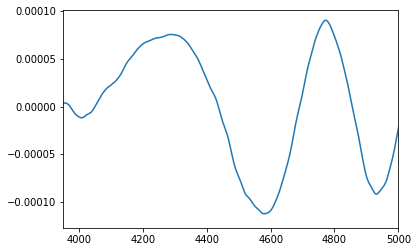

In [241]:
plt.plot(dfs[0]["x"])
plt.xlim((3950, 5000))

In [242]:
_df = dfs[0]
#df = df.iloc[4000:4*(4000 + int(1/0.000195))]

_df = _df.iloc[3950:]
t = (_df["datetime"] - _df["datetime"].iloc[0]).apply(lambda x: x.delta*1e-9)
t_div = t.apply(lambda x: x//1)

params_history = []
for section in t_div.unique():
    
    
    df = _df.loc[t_div[t_div==section].index]
    mass = 1
    window = 320
    df["fx_"] = df["fx"] - mass*df["x_dot2"]
    df["fy_"] = df["fy"] - mass*df["y_dot2"]
    _params_history = []
    for i in tqdm(range(df.shape[0] - window)):
        X = df[["x_dot", "y_dot", "x", "y"]].values[i:(i+window)]

        Y = df[["fx_", "fy_"]].values[i:(i+window)]
        params = np.linalg.inv( X.transpose() @ X ) @ X.transpose() @ Y
        _params_history.append(params)
        
    params_history.append(_params_history)

params_history_x = np.array(params_history)


100%|██████████| 849/849 [00:00<00:00, 950.85it/s]
<ipython-input-242-947d51bd2e09>:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  params_history_x = np.array(params_history)


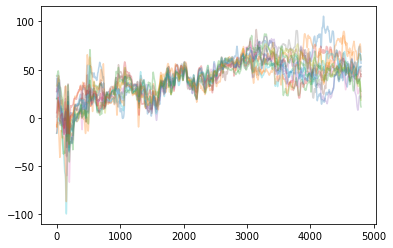

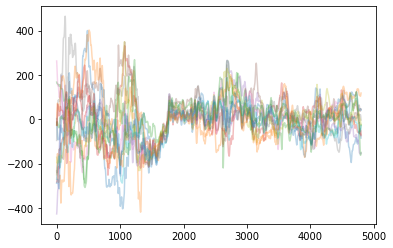

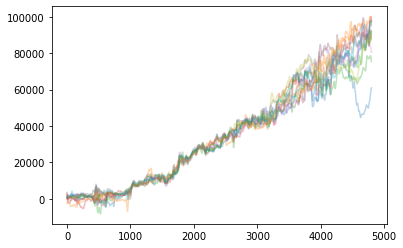

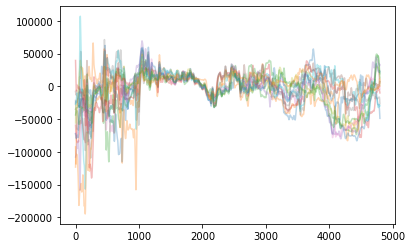

In [243]:
#plt.plot(params_history_x[:, :, 0, 0].transpose())
for i in range(4):
    for section in params_history_x:
        section = np.array(section)[:, i, 0]
        plt.plot(section, alpha=0.3)
    plt.show()

In [244]:
for i in params_history_x:
    print(np.array(i).shape)

(4800, 4, 2)
(4800, 4, 2)
(4800, 4, 2)
(4800, 4, 2)
(4800, 4, 2)
(4800, 4, 2)
(4800, 4, 2)
(4800, 4, 2)
(4800, 4, 2)
(4800, 4, 2)
(4800, 4, 2)
(4800, 4, 2)
(4800, 4, 2)
(849, 4, 2)


In [245]:
params_history_x = params_history_x[:-1]

In [246]:
params_history_x = np.array(params_history_x)
params_history_x = np.array(list(map(np.array, params_history_x))).squeeze()

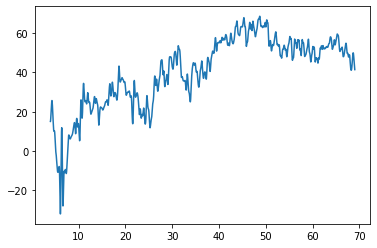

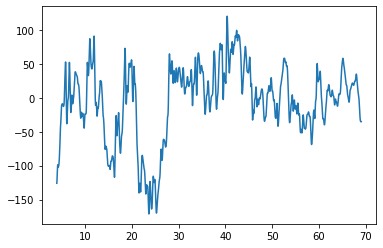

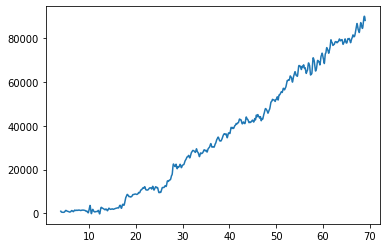

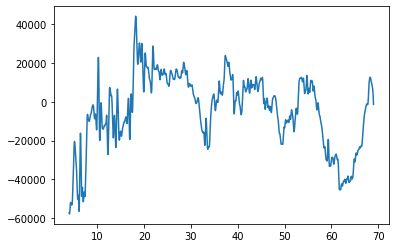

In [247]:
params_history = params_history_x[:, :, :, 0]
params_history = np.mean(params_history, axis=0)
x = np.linspace(4, 69, params_history.shape[0])
for i in range(params_history.shape[1]):
    plt.plot(x, params_history[:,i])
    plt.show()

In [248]:
params_history.shape

(4800, 4)

(3950.0, 5000.0)

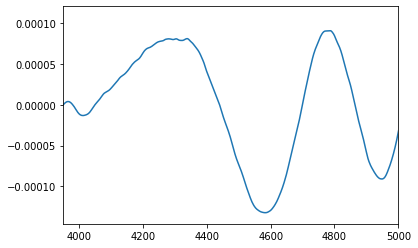

In [249]:
plt.plot(dfs[-1]["y"])
plt.xlim((3950, 5000))

In [250]:
_df = dfs[-1]
#df = df.iloc[4000:4*(4000 + int(1/0.000195))]

_df = _df.iloc[3950:]
t = (_df["datetime"] - _df["datetime"].iloc[0]).apply(lambda x: x.delta*1e-9)
t_div = t.apply(lambda x: x//1)

params_history = []
for section in t_div.unique():
    
    
    df = _df.loc[t_div[t_div==section].index]
    mass = 1
    window = 320
    df["fx_"] = df["fx"] - mass*df["x_dot2"]
    df["fy_"] = df["fy"] - mass*df["y_dot2"]
    _params_history = []
    for i in tqdm(range(df.shape[0] - window)):
        X = df[["x_dot", "y_dot", "x", "y"]].values[i:(i+window)]

        Y = df[["fx_", "fy_"]].values[i:(i+window)]
        params = np.linalg.inv( X.transpose() @ X ) @ X.transpose() @ Y
        _params_history.append(params)
        
    params_history.append(_params_history)

params_history_y = np.array(params_history)


100%|██████████| 849/849 [00:00<00:00, 871.88it/s]
<ipython-input-250-5cc47800d41f>:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  params_history_y = np.array(params_history)


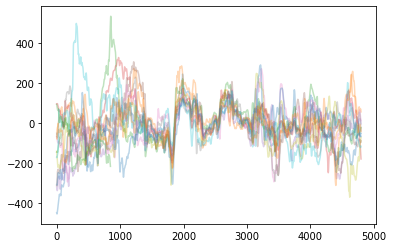

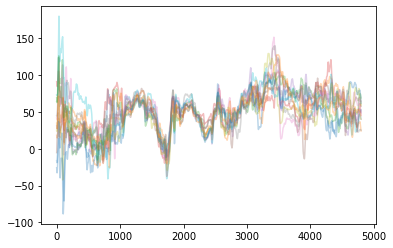

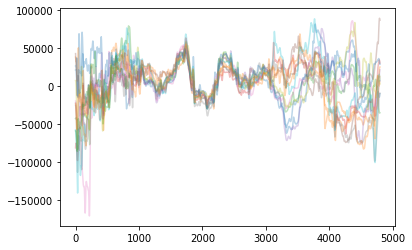

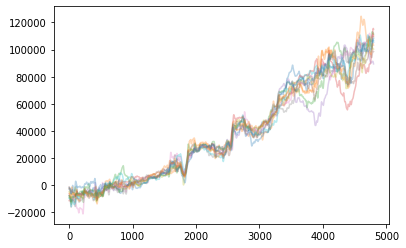

In [251]:
#plt.plot(params_history_x[:, :, 0, 0].transpose())
for i in range(4):
    for section in params_history_y:
        section = np.array(section)[:, i, 1]
        plt.plot(section, alpha=0.3)
    plt.show()

In [252]:
for i in params_history_y:
    print(np.array(i).shape)

(4800, 4, 2)
(4800, 4, 2)
(4800, 4, 2)
(4800, 4, 2)
(4800, 4, 2)
(4800, 4, 2)
(4800, 4, 2)
(4800, 4, 2)
(4800, 4, 2)
(4800, 4, 2)
(4800, 4, 2)
(4800, 4, 2)
(849, 4, 2)


In [253]:
params_history_y = params_history_y[:-1]

In [254]:
params_history_y = np.array(params_history_y)
params_history_y = np.array(list(map(np.array, params_history_y))).squeeze()

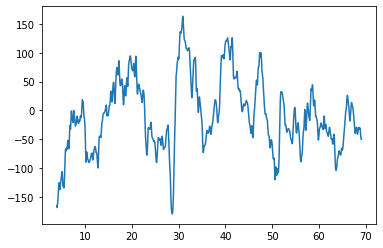

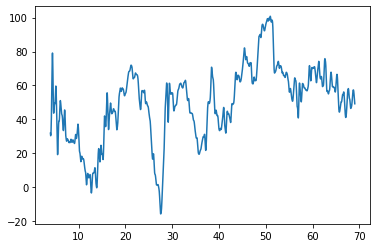

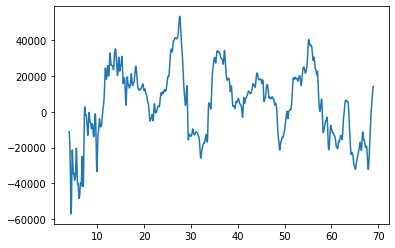

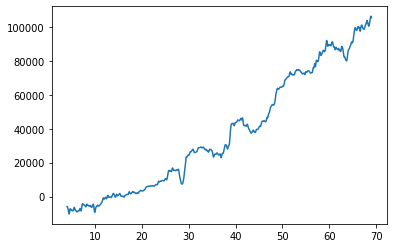

In [255]:
params_history = params_history_y[:, :, :, 1]
params_history = np.mean(params_history, axis=0)
x = np.linspace(4, 69, params_history.shape[0])
for i in range(params_history.shape[1]):
    plt.plot(x, params_history[:,i])
    plt.show()

# Tentando unir os dados em x e y para ver se melhora o resultado

In [256]:
dfs[0]

,datetime,x,y,fx,fy,x_dot,x_dot2,y_dot,y_dot2,fx_dot,fx_dot2,fy_dot,fy_dot2
4,2019-03-24 02:00:56.426152,0.000017,-2.768188e-07,-0.581409,0.497498,-0.011693,3.464478,0.000876,-0.423289,-14.441614,383940.749706,-981.602867,1.098964e+06
5,2019-03-24 02:00:56.426348,0.000015,-1.163659e-07,-0.589420,0.303190,-0.010964,2.948980,0.000787,-0.355575,54.019672,319207.709114,-781.406505,9.562381e+05
6,2019-03-24 02:00:56.426543,0.000013,2.860557e-08,-0.581050,0.153211,-0.010339,2.480769,0.000711,-0.294116,110.424668,260248.142371,-607.939855,8.247448e+05
7,2019-03-24 02:00:56.426738,0.000011,1.605240e-07,-0.559374,0.041009,-0.009810,2.057955,0.000648,-0.238667,155.876768,206831.962943,-459.052676,7.040723e+05
8,2019-03-24 02:00:56.426934,0.000009,2.815981e-07,-0.527165,-0.039392,-0.009369,1.678653,0.000596,-0.188982,191.434498,158729.084300,-332.675067,5.938088e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...
71690,2019-03-24 02:01:10.424981,0.000027,-3.445288e-06,-0.758024,0.124071,-0.007503,0.139220,-0.000025,0.253550,97.558594,350943.894087,104.868356,3.327773e+05
71691,2019-03-24 02:01:10.425176,0.000025,-3.444616e-06,-0.731671,0.151074,-0.007468,0.037745,0.000020,0.295026,174.712137,442022.984279,177.324700,4.117604e+05
71692,2019-03-24 02:01:10.425371,0.000024,-3.430636e-06,-0.687198,0.193619,-0.007450,-0.089803,0.000074,0.338765,270.604833,543213.993493,266.011375,4.993046e+05
71693,2019-03-24 02:01:10.425566,0.000022,-3.400759e-06,-0.620377,0.255022,-0.007455,-0.244884,0.000135,0.384805,387.251594,654958.836734,372.634276,5.957841e+05


In [257]:
_df_x = dfs[0]
_df_y = dfs[-1]
#df = df.iloc[4000:4*(4000 + int(1/0.000195))]

_df_x = _df_x.iloc[3950:]
_df_y = _df_y.iloc[3950:]

t = (_df_x["datetime"] - _df_x["datetime"].iloc[0]).apply(lambda x: x.delta*1e-9)
t_div = t.apply(lambda x: x//1)

params_history = []
variance_history = []
for section in t_div.unique():
    
    try:
        df_x = _df_x.loc[t_div[t_div==section].index]
        df_y = _df_y.loc[t_div[t_div==section].index]

        mass = 1
        window = 320

        df_x["fx_"] = df_x["fx"] - mass*df_x["x_dot2"]
        df_x["fy_"] = df_x["fy"] - mass*df_x["y_dot2"]
        df_y["fx_"] = df_y["fx"] - mass*df_y["x_dot2"]
        df_y["fy_"] = df_y["fy"] - mass*df_y["y_dot2"]

        _params_history = []
        _variance_history = []
        for i in tqdm(range(df_x.shape[0] - window)):
            X_x = df_x[["x_dot", "y_dot", "x", "y"]].values[i:(i+window)]
            X_y = df_y[["x_dot", "y_dot", "x", "y"]].values[i:(i+window)]

            Y_x = df_x[["fx_", "fy_"]].values[i:(i+window)]
            Y_y = df_y[["fx_", "fy_"]].values[i:(i+window)]

            X = np.concatenate([X_x, X_y], axis=0)
            Y = np.concatenate([Y_x, Y_y], axis=0)

            params = np.linalg.inv( X.transpose() @ X ) @ X.transpose() @ Y
            
            Y_hat = X @ params
            std_dev_hat = np.sum(np.square(Y - Y_hat), axis=0) / (X.shape[0] - X.shape[1] - 1)
            variance_x = np.linalg.inv( X.transpose() @ X ) * std_dev_hat[0]
            variance_y = np.linalg.inv( X.transpose() @ X ) * std_dev_hat[1]
            variance = np.concatenate([variance_x, variance_y], axis=0)
            _params_history.append(params)
            _variance_history.append(variance)

        params_history.append(_params_history)
        variance_history.append(_variance_history)
    except Exception as e:
        print(e)
        pass
    
params_history_all = np.array(params_history)
variance_history_all = np.array(variance_history)


100%|██████████| 4800/4800 [00:11<00:00, 403.60it/s]


"Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: Int64Index([66574, 66576, 66577, 66578, 66579,\n            ...\n            70521, 70522, 70523, 70524, 70525],\n           dtype='int64', length=3951). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"
"None of [Int64Index([70526, 70527, 70528, 70529, 70530, 70531, 70532, 70533, 70534,\n            70535,\n            ...\n            71685, 71686, 71687, 71688, 71689, 71690, 71691, 71692, 71693,\n            71694],\n           dtype='int64', length=1169)] are in the [index]"


In [258]:
params_history = np.array(params_history_all)
variance_history = np.array(variance_history_all)

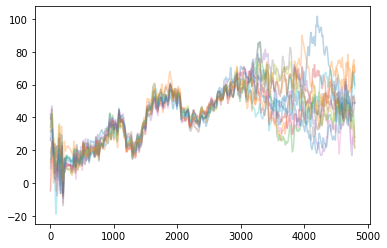

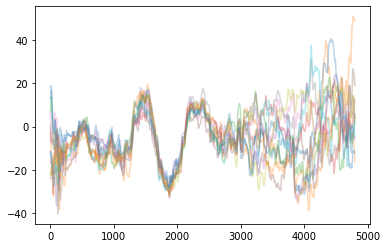

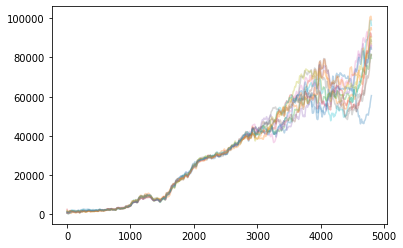

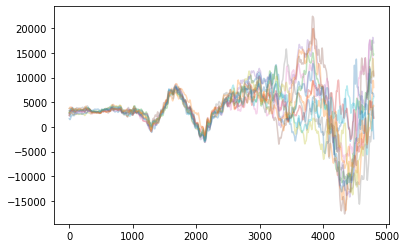

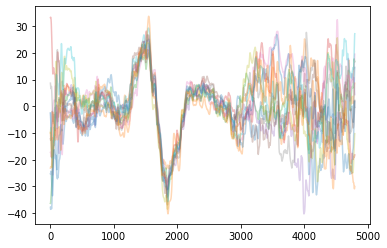

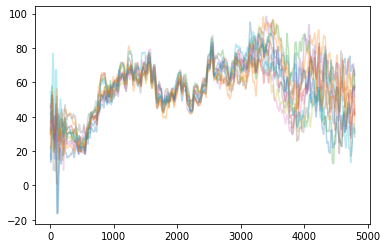

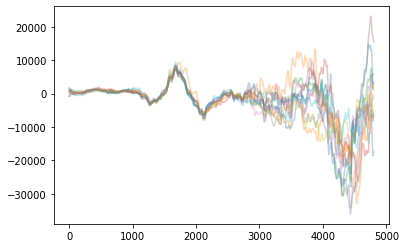

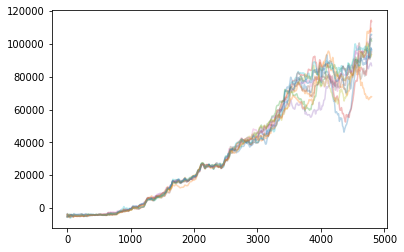

In [259]:
#plt.plot(params_history_x[:, :, 0, 0].transpose())

for i in range(4):
    for section in params_history:
        section = np.array(section)[:, i, 0]
        plt.plot(section, alpha=0.3)
    plt.show()
    
for i in range(4):
    for section in params_history:
        section = np.array(section)[:, i, 1]
        plt.plot(section, alpha=0.3)
    plt.show()

In [260]:
variance_history.shape

(12, 4800, 8, 4)

In [261]:
np.sqrt(np.diagonal(variance_history[4, 4300, 4:]))

array([   6.53834314,    5.63624339, 2605.00791407, 2456.21207042])

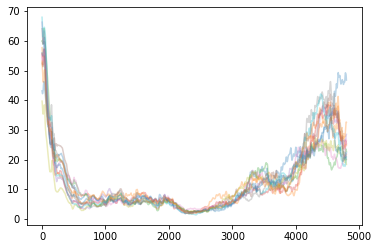

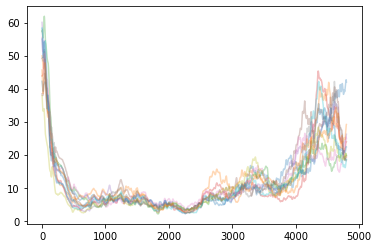

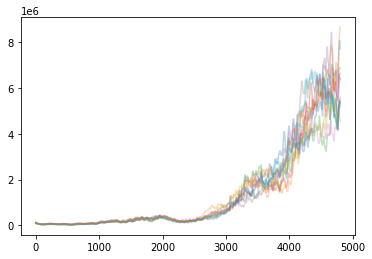

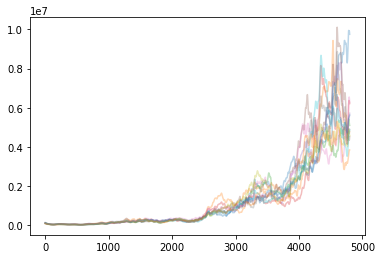

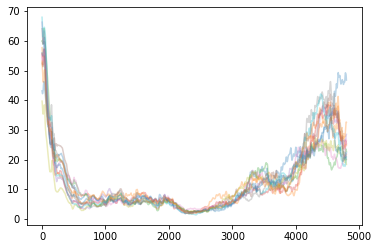

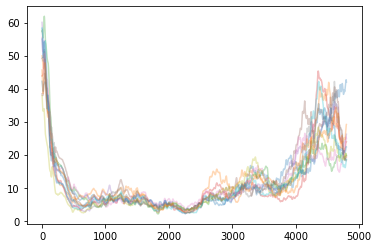

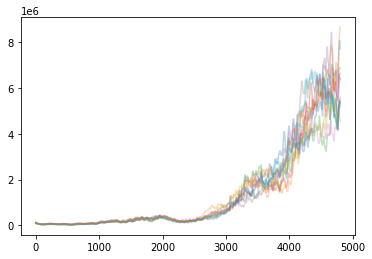

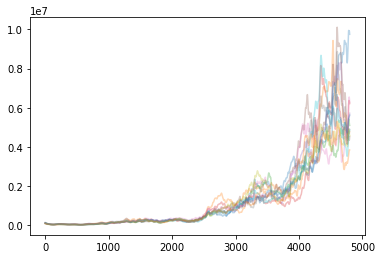

In [262]:
for i in range(4):
    for section in variance_history:
        section = np.array(section)[:, i, i%4]
        plt.plot(section, alpha=0.3)
    plt.show()
    
for i in range(4):
    for section in variance_history:
        section = np.array(section)[:, i, i%4]
        plt.plot(section, alpha=0.3)
    plt.show()

In [263]:
params_history.shape

(12, 4800, 4, 2)

In [264]:
params_history = np.median(params_history, axis=0)

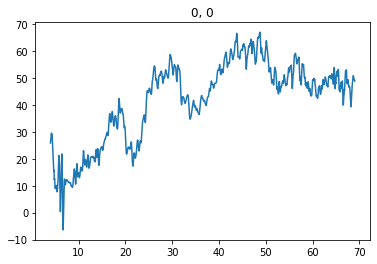

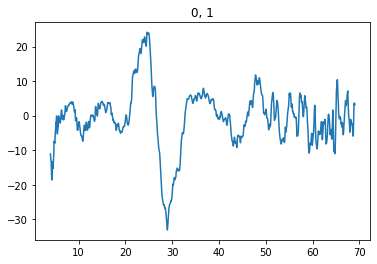

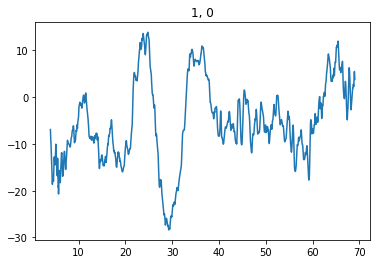

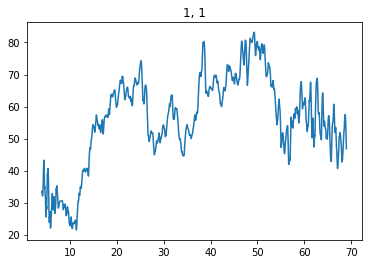

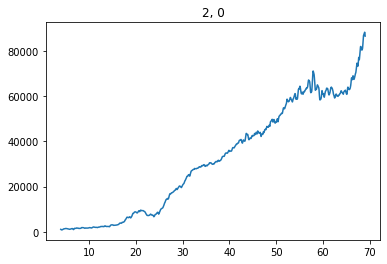

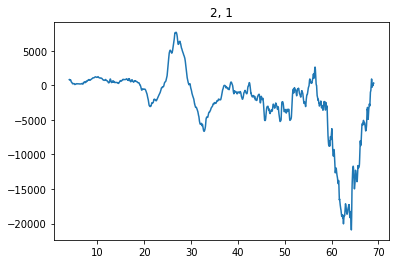

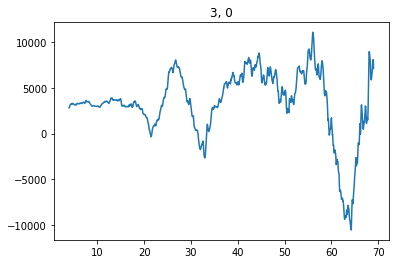

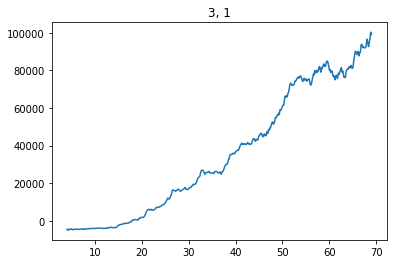

In [265]:

x = np.linspace(4, 69, params_history.shape[0])
for i in range(params_history.shape[1]):
    for j in range(params_history.shape[2]):
        plt.plot(x, params_history[:,i, j])
        plt.title(f"{i}, {j}")
        plt.show()

In [266]:
F = np.linspace(4, 69, params_history.shape[0])
C = params_history[:, :2,]
K = params_history[:, 2:,]


sweep_results_lin_reg = {"freq" : F,
                         "C" : C,
                         "K" : K}

In [267]:
import pickle
with open("../notebooks/results/linreg_sweep_results.pickle", "wb") as f:
    pickle.dump(sweep_results_lin_reg, f)

# Todos de uma vez

In [139]:
t_div

3954      0.0
3955      0.0
3956      0.0
3957      0.0
3958      0.0
         ... 
71690    13.0
71691    13.0
71692    13.0
71693    13.0
71694    13.0
Name: datetime, Length: 67729, dtype: float64

In [144]:
t_rest

3954     0.000000
3955     0.000195
3956     0.000390
3957     0.000586
3958     0.000781
           ...   
71690    0.227344
71691    0.227539
71692    0.227734
71693    0.227929
71694    0.228125
Name: datetime, Length: 67729, dtype: float64

In [145]:
_df_x = dfs[0]
_df_y = dfs[-1]
#df = df.iloc[4000:4*(4000 + int(1/0.000195))]

_df_x = _df_x.iloc[3950:]
_df_y = _df_y.iloc[3950:]

t = (_df_x["datetime"] - _df_x["datetime"].iloc[0]).apply(lambda x: x.delta*1e-9)
t_rest = t.apply(lambda x: x // 0.000195)

params_history = []
for section in t_rest.unique():
    
    
    df_x = _df_x.loc[t_rest[t_rest==section].index]
    df_y = _df_y.loc[t_rest[t_rest==section].index]

    mass = 1
    #window = 200 #320

    df_x["fx_"] = df_x["fx"] - mass*df_x["x_dot2"]
    df_x["fy_"] = df_x["fy"] - mass*df_x["y_dot2"]
    df_y["fx_"] = df_y["fx"] - mass*df_y["x_dot2"]
    df_y["fy_"] = df_y["fy"] - mass*df_y["y_dot2"]
    
    X_x = df_x[["x_dot", "y_dot", "x", "y"]].values[i:(i+window)]
    X_y = df_y[["x_dot", "y_dot", "x", "y"]].values[i:(i+window)]

    Y_x = df_x[["fx_", "fy_"]].values[i:(i+window)]
    Y_y = df_y[["fx_", "fy_"]].values[i:(i+window)]

    X = np.concatenate([X_x, X_y], axis=0)
    Y = np.concatenate([Y_x, Y_y], axis=0)

    params = np.linalg.inv( X.transpose() @ X ) @ X.transpose() @ Y
    
    params_history.append(params)

    
params_history_all = np.array(params_history)


LinAlgError: Singular matrix

In [118]:
params_history = np.array(params_history_all)

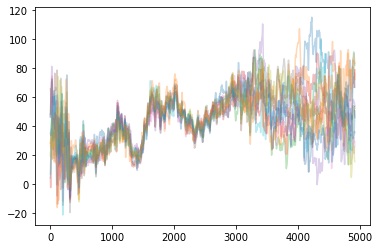

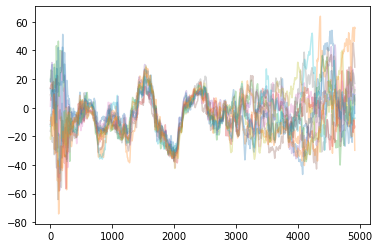

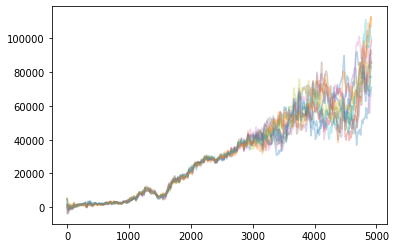

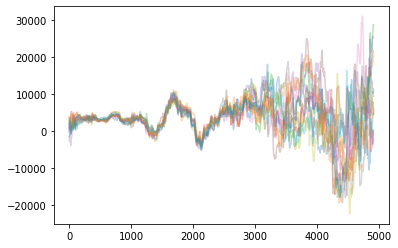

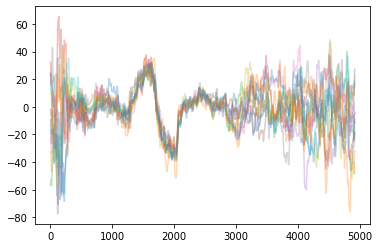

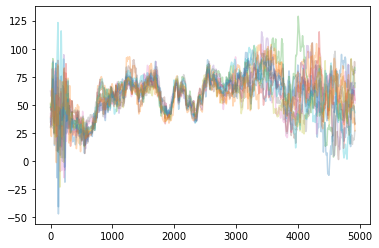

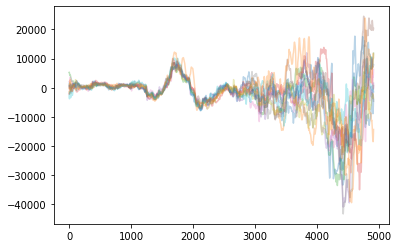

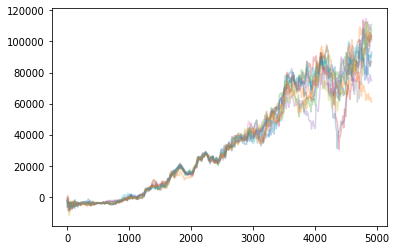

In [119]:
#plt.plot(params_history_x[:, :, 0, 0].transpose())

for i in range(4):
    for section in params_history:
        section = np.array(section)[:, i, 0]
        plt.plot(section, alpha=0.3)
    plt.show()
    
for i in range(4):
    for section in params_history:
        section = np.array(section)[:, i, 1]
        plt.plot(section, alpha=0.3)
    plt.show()

In [93]:
params_history.shape

(12, 4920, 4, 2)

In [94]:
params_history = np.median(params_history, axis=0)

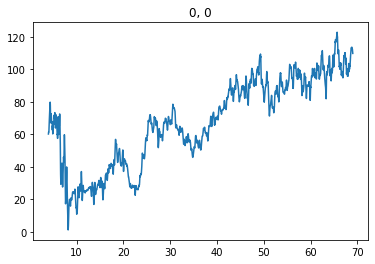

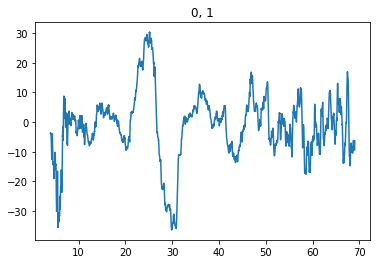

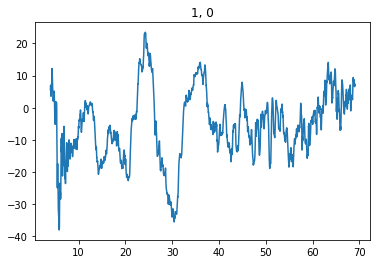

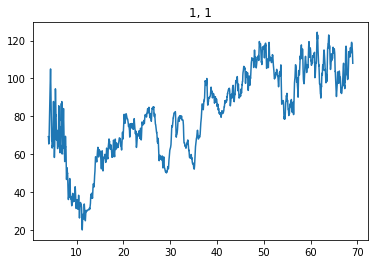

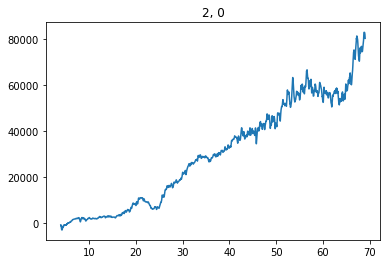

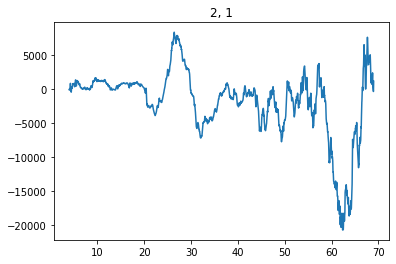

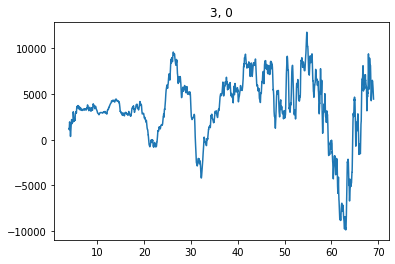

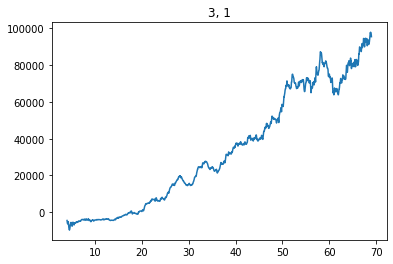

In [95]:

x = np.linspace(4, 69, params_history.shape[0])
for i in range(params_history.shape[1]):
    for j in range(params_history.shape[2]):
        plt.plot(x, params_history[:,i, j])
        plt.title(f"{i}, {j}")
        plt.show()

In [122]:
import statsmodels.api as sm

print(X.shape)
print(Y.shape)
sm.OLS(Y[:, 0], X).fit()

(400, 4)
(400, 2)


statsmodels.iolib.summary.Summary

In [124]:
_df_x = dfs[0]
_df_y = dfs[-1]
#df = df.iloc[4000:4*(4000 + int(1/0.000195))]

_df_x = _df_x.iloc[3950:]
_df_y = _df_y.iloc[3950:]

t = (_df_x["datetime"] - _df_x["datetime"].iloc[0]).apply(lambda x: x.delta*1e-9)
t_div = t.apply(lambda x: x//1)

params_history = []
for section in t_div.unique():
    
    try:
        df_x = _df_x.loc[t_div[t_div==section].index]
        df_y = _df_y.loc[t_div[t_div==section].index]

        mass = 1
        window = 200 #320

        df_x["fx_"] = df_x["fx"] - mass*df_x["x_dot2"]
        df_x["fy_"] = df_x["fy"] - mass*df_x["y_dot2"]
        df_y["fx_"] = df_y["fx"] - mass*df_y["x_dot2"]
        df_y["fy_"] = df_y["fy"] - mass*df_y["y_dot2"]

        _params_history = []
        for i in tqdm(range(df_x.shape[0] - window)):
            X_x = df_x[["x_dot", "y_dot", "x", "y"]].values[i:(i+window)]
            X_y = df_y[["x_dot", "y_dot", "x", "y"]].values[i:(i+window)]

            Y_x = df_x[["fx_", "fy_"]].values[i:(i+window)]
            Y_y = df_y[["fx_", "fy_"]].values[i:(i+window)]

            X = np.concatenate([X_x, X_y], axis=0)
            Y = np.concatenate([Y_x, Y_y], axis=0)
            
            fit_x = sm.OLS(Y[:, 0], X).fit()
            fit_y = sm.OLS(Y[:, 1], X).fit()
            _params_history.append({"x":fit_x, "y": fit_y})

        params_history.append(_params_history)
    except:
        pass
    
params_history_all = np.array(params_history)


100%|██████████| 4920/4920 [00:14<00:00, 334.72it/s]


In [138]:
len(params_history)

12